In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from c200_sdk.sdk_array_newsystem import SDKArray
from C200_utils import data_quantization_sym
from scipy import stats

/usr/local/python38/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


# 1. 创建cpu模型、加载权重并测试

In [2]:
def mnist():
    from torchvision import datasets, transforms
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=64, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])),
        batch_size=1000, shuffle=True)
    return train_loader, test_loader

def test(net):
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for x, y in test_loader:
            x = torch.nn.functional.max_pool2d(x, 2).reshape(x.shape[0], -1)#.cuda()
            x[x < 1.] = 0.
            x[x > 0.] = 1.
            output = net(x)
            y = y#.cuda()
            _, predicted = torch.max(output, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    return correct/total


class MLP2(torch.nn.Module):
    def __init__(self, p_1=0.5, p_2=0.5):
        super(MLP2, self).__init__()
        input_dim, output_dim, hidden_dim = 196, 10, 128
        
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim, bias=False)
        self.dropout_1 = torch.nn.Dropout(p_1)
        self.fc2 = torch.nn.Linear(hidden_dim, output_dim, bias=False)
        self.dropout_2 = torch.nn.Dropout(p_2)
        # self.fc3 = torch.nn.Linear(hidden_dim, output_dim, bias=False)

    def forward(self, x):
        x = self.dropout_1(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout_2(x)
        x = torch.relu(self.fc2(x))
        
        # x = torch.relu(self.fc3(x))
        return x

net = MLP2(p_1=0.5, p_2=0.5)

net.load_state_dict(torch.load('model_nobias_2lys.pth'))

train_loader, test_loader = mnist()


test(net)

0.9663

# 2. 确保 Memristor 上的 fidelity 

## 2.1 第一步：确保 calculate 原子操作的正确性

libBaseApi version:11
初始化
选片

Time used: 0:00:00.933199
(100, 128)
[[1.         0.91595013]
 [0.91595013 1.        ]]


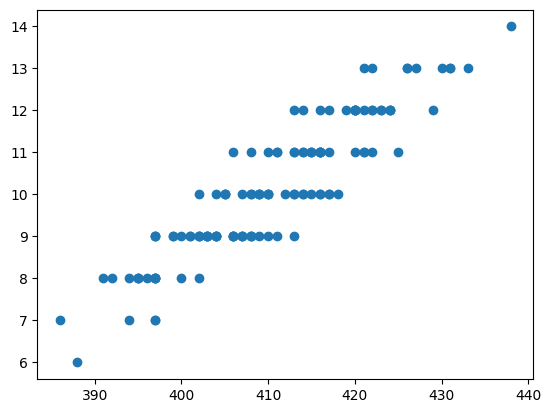

In [3]:
sdk = SDKArray(1)
x_input = torch.randint(0, 2, [1, 100])
weight_on_chip = [0, 0, 100, 128]
weight = sdk.get_weight(weight_on_chip)
y_cpu = x_input @ weight
y_mem = sdk.calculate(x_input, addr=weight_on_chip, it_time=10).astype(np.float32) # 注意这里的y_mem是uint8，要立即转为int8，才能-8是不出错

corr = np.corrcoef(y_cpu.numpy().reshape(1, -1)[0], y_mem.reshape(1, -1)[0])
print(corr)
plt.scatter(y_cpu.numpy().reshape(1, -1)[0], y_mem.reshape(1, -1)[0])
plt.show()

以上已经确保了线性映射是合意的，但是scale上相比input（横轴）有一个4-bit的量化。

In [4]:
y_mem.min(), y_mem.max()

(6.0, 14.0)

### +8 / -8 问题

In [5]:
x = np.random.randint(0, 2, [1, 8])
w = np.random.randint(-7, 7, [8, 6])
print("x: ", x)
print("w: ", w)
print("x @ w: \n", x @ w)
print("x @ (w+8)) - 8 * x.sum(): \n", x @ (w+8) - 8 * x.sum())

x:  [[1 1 1 1 1 1 1 1]]
w:  [[-1  2  3 -4 -1 -5]
 [ 5 -1  3 -7  0  4]
 [ 5  2 -5 -3  2 -3]
 [-4 -3 -2  3 -7  5]
 [ 0 -5 -4  0  0  2]
 [-7 -6  1 -3 -7  0]
 [ 0  6 -5 -7  3  6]
 [-1 -2  5  4  6  4]]
x @ w: 
 [[ -3  -7  -4 -17  -4  13]]
x @ (w+8)) - 8 * x.sum(): 
 [[ -3  -7  -4 -17  -4  13]]


故理论上总是可以通过 `(x @ (w+8)) - 8 * x.sum()` 映射来保持 scale

In [6]:
y_mem - 8 * x_input.numpy().sum()

array([[-392., -387., -393., -394., -389., -391., -392., -387., -390.,
        -390., -388., -389., -388., -387., -390., -391., -391., -391.,
        -392., -387., -390., -391., -392., -389., -390., -389., -391.,
        -389., -389., -390., -391., -387., -388., -388., -391., -393.,
        -391., -388., -390., -391., -389., -389., -389., -389., -390.,
        -387., -389., -387., -390., -391., -392., -389., -391., -391.,
        -386., -392., -388., -391., -391., -387., -392., -389., -389.,
        -392., -391., -390., -390., -390., -391., -390., -390., -390.,
        -388., -388., -391., -390., -391., -388., -391., -391., -391.,
        -388., -391., -389., -391., -390., -388., -390., -392., -387.,
        -389., -388., -388., -389., -391., -388., -391., -389., -393.,
        -391., -389., -390., -391., -389., -390., -390., -391., -392.,
        -388., -393., -390., -389., -388., -390., -389., -390., -391.,
        -392., -388., -389., -388., -392., -390., -388., -392., -391.,
      

然而，实际这么做发现还不对，因为`y_mem`总是先被`calculate`固定到了$[1, 14)$。因此只需要$-8$，道理就是在此。

In [7]:
y_mem - 8 

array([[ 0.,  5., -1., -2.,  3.,  1.,  0.,  5.,  2.,  2.,  4.,  3.,  4.,
         5.,  2.,  1.,  1.,  1.,  0.,  5.,  2.,  1.,  0.,  3.,  2.,  3.,
         1.,  3.,  3.,  2.,  1.,  5.,  4.,  4.,  1., -1.,  1.,  4.,  2.,
         1.,  3.,  3.,  3.,  3.,  2.,  5.,  3.,  5.,  2.,  1.,  0.,  3.,
         1.,  1.,  6.,  0.,  4.,  1.,  1.,  5.,  0.,  3.,  3.,  0.,  1.,
         2.,  2.,  2.,  1.,  2.,  2.,  2.,  4.,  4.,  1.,  2.,  1.,  4.,
         1.,  1.,  1.,  4.,  1.,  3.,  1.,  2.,  4.,  2.,  0.,  5.,  3.,
         4.,  4.,  3.,  1.,  4.,  1.,  3., -1.,  1.,  3.,  2.,  1.,  3.,
         2.,  2.,  1.,  0.,  4., -1.,  2.,  3.,  4.,  2.,  3.,  2.,  1.,
         0.,  4.,  3.,  4.,  0.,  2.,  4.,  0.,  1.,  1.,  1.]],
      dtype=float32)

不过另一方面也为真正的矩阵乘矩阵提供了重要启发，我们可以通过统计输入的`.sum()`来把得到的结果放缩回去。

In [8]:
(y_mem - 8) * x_input.numpy().sum()

array([[   0.,  250.,  -50., -100.,  150.,   50.,    0.,  250.,  100.,
         100.,  200.,  150.,  200.,  250.,  100.,   50.,   50.,   50.,
           0.,  250.,  100.,   50.,    0.,  150.,  100.,  150.,   50.,
         150.,  150.,  100.,   50.,  250.,  200.,  200.,   50.,  -50.,
          50.,  200.,  100.,   50.,  150.,  150.,  150.,  150.,  100.,
         250.,  150.,  250.,  100.,   50.,    0.,  150.,   50.,   50.,
         300.,    0.,  200.,   50.,   50.,  250.,    0.,  150.,  150.,
           0.,   50.,  100.,  100.,  100.,   50.,  100.,  100.,  100.,
         200.,  200.,   50.,  100.,   50.,  200.,   50.,   50.,   50.,
         200.,   50.,  150.,   50.,  100.,  200.,  100.,    0.,  250.,
         150.,  200.,  200.,  150.,   50.,  200.,   50.,  150.,  -50.,
          50.,  150.,  100.,   50.,  150.,  100.,  100.,   50.,    0.,
         200.,  -50.,  100.,  150.,  200.,  100.,  150.,  100.,   50.,
           0.,  200.,  150.,  200.,    0.,  100.,  200.,    0.,   50.,
      

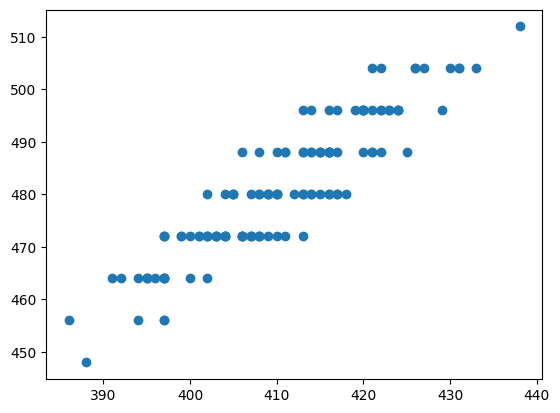

In [9]:
plt.scatter(y_cpu, 8 * (y_mem + x_input.numpy().sum()))
plt.show()

In [10]:
# estimate slope and interception
stats.linregress(y_mem, y_cpu)

/usr/local/python38/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:195: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/usr/local/python38/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:198: RuntimeWarning: invalid value encountered in sqrt
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


LinregressResult(slope=5.868713830164166, intercept=351.0021731427897, rvalue=0.9159501268452422, pvalue=nan, stderr=nan, intercept_stderr=nan)

In [11]:
stats.linregress(y_cpu, 8 * (y_mem + x_input.numpy().sum()))

LinregressResult(slope=1.143643611389853, intercept=11.632536387321295, rvalue=0.9159501268452422, pvalue=nan, stderr=nan, intercept_stderr=nan)

至此，expanded 场景下的vmm已经具备了相当的fidelity。

## 2.2 第二步：考虑权重量化并封装成矩阵乘矩阵的linear可用形式

由于在量输入2-bit量化版本的实验中，输入量化是自然满足因而不必单独考虑的。只有权重量化 matters。

考虑到ReRAM实际计算中的权重量化后必须以整数展示，因而一旦计算完成，我们希望立即进行一个还原映射来恢复其原数值scale。

正式给出量化和反量化函数：

In [12]:
# Quantize input data
def quant(data_float, scale=None, half_level=127):
    if scale == None:
        scale = abs(data_float).max()
        if scale == 0:
            return data_float, 0

    data_quantized = (data_float / scale * half_level).round()
    return data_quantized, scale

def quant_reverse(vector_quant, scale, half_level=127):
    vector_quant_reverse = vector_quant * scale / half_level
    return vector_quant_reverse

现在开始正式考虑权重量化问题，直接加载已经训练好的真实权重：

In [13]:
weight_pretrained = torch.load('model_nobias_2lys.pth')['fc1.weight']
weight_pretrained

tensor([[-0.0401,  0.0264,  0.0552,  ..., -0.3393, -0.0467,  0.0134],
        [ 0.0340,  0.0532, -0.0206,  ...,  0.1552,  0.0644,  0.0067],
        [-0.0177, -0.0214, -0.0304,  ..., -0.3164,  0.0388,  0.0237],
        ...,
        [-0.0594, -0.0557, -0.0624,  ...,  0.1052,  0.0585, -0.0488],
        [ 0.0301, -0.0410, -0.0688,  ..., -0.1005, -0.0174, -0.0116],
        [-0.0611, -0.0104, -0.0291,  ...,  0.1569, -0.0044,  0.0116]])

对权重测试量化函数：

In [14]:
weight_pretrained_quant, scale = quant(weight_pretrained, scale=None, half_level=7)
weight_pretrained_quant, scale

(tensor([[-0.,  0.,  0.,  ..., -1., -0.,  0.],
         [ 0.,  0., -0.,  ...,  1.,  0.,  0.],
         [-0., -0., -0.,  ..., -1.,  0.,  0.],
         ...,
         [-0., -0., -0.,  ...,  0.,  0., -0.],
         [ 0., -0., -0.,  ..., -0., -0., -0.],
         [-0., -0., -0.,  ...,  1., -0.,  0.]]),
 tensor(1.7059))

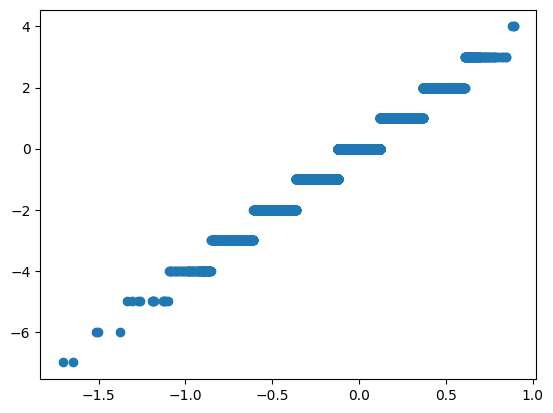

In [15]:
plt.scatter(weight_pretrained, weight_pretrained_quant)
plt.show()

测试还原映射是否能恢复scale：

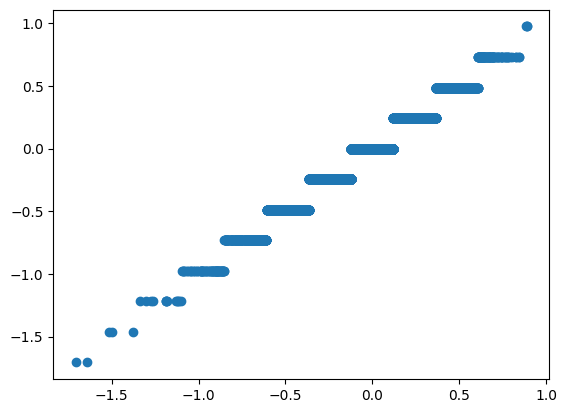

[[1.         0.95820065]
 [0.95820065 1.        ]]


In [16]:
plt.scatter(weight_pretrained, quant_reverse(weight_pretrained_quant, scale, half_level=7))
plt.show()
print(np.corrcoef(weight_pretrained.numpy().reshape(1, -1)[0], quant_reverse(weight_pretrained_quant, scale, half_level=7).numpy().reshape(1, -1)[0]))

可见权重方面已经保证了线性和scale两个方面。但是以上仅考虑了权重本身，实际的运算中，权重在scale变换后，要经过vvm才能被还原。实际上，由于

$$
\mathbf{x}(c\mathbf{W})=c~\mathbf{xW},
$$

可以直接进行还原。
根据以上认识，我们可以把上述权重实际刷入ReRAM来验证整个逻辑是否可以保证fidelity：

In [17]:
addr_fc1 = [0, 0, 196, 128]
sdk.set_weight(weight=weight_pretrained_quant.T+8, addr=addr_fc1, verbose = 0, prog_cycle = 5)

(196, 128)
(196, 128)
cell_total_num:25088


Cycle = 1
Progress at 100.00 %
Total time used: 0:00:34
Mapping success rate: 25088 / 25088, 100.0000
Operation success rate: 13839 / 13839, 100.0000


Cycle = 2
Progress at 100.00 %
Total time used: 0:00:53
Mapping success rate: 25088 / 25088, 100.0000
Operation success rate: 10595 / 10595, 100.0000


Cycle = 3
Progress at 100.00 %
Total time used: 0:01:08
Mapping success rate: 25088 / 25088, 100.0000
Operation success rate: 9244 / 9244, 100.0000


Cycle = 4
Progress at 100.00 %
Total time used: 0:01:21
Mapping success rate: 25088 / 25088, 100.0000
Operation success rate: 8604 / 8604, 100.0000


Cycle = 5
Progress at 100.00 %
Total time used: 0:01:33
Mapping success rate: 25088 / 25088, 100.0000
Operation success rate: 8251 / 8251, 100.0000


In [18]:
x_input = torch.randint(0, 2, [1, 196])
sdk.calculate(x_input, addr=addr_fc1, it_time=10)

array([[10, 11,  7,  5, 12, 10, 10, 10, 12, 13, 10, 11, 12, 11, 12,  9,
         7,  8, 12, 14, 15, 11,  6, 11, 13, 10,  7,  9, 10,  9,  8, 10,
        12, 11, 11,  8, 12,  8, 12,  8,  9, 12, 10,  8,  8,  7, 11, 11,
        15, 14,  9,  9, 10, 10, 13,  8, 11, 11,  9, 10,  5, 11, 12,  6,
        10, 13, 11,  4,  7,  9,  8, 10, 12,  7,  8, 10,  8,  7, 11, 11,
        11, 13, 13, 11,  8, 10,  8,  9, 14,  9,  7, 11, 11,  9,  8, 12,
         9,  9,  8,  6, 12,  8, 12,  5, 12,  9, 11,  8, 13,  9, 12, 11,
        11, 13, 13,  7, 10,  9,  8, 10,  8,  7,  8, 13,  9, 11, 10, 13]],
      dtype=uint8)

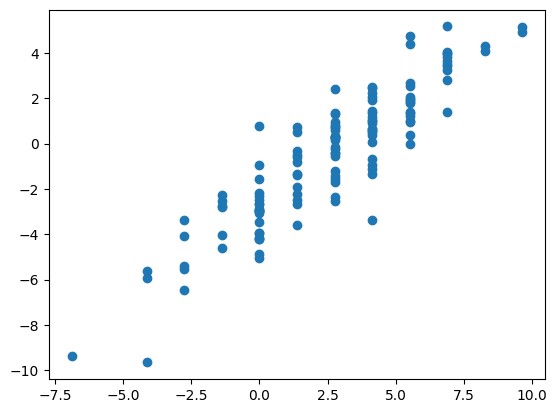

[[1.         0.90392274]
 [0.90392274 1.        ]]


LinregressResult(slope=0.9448203436681766, intercept=3.0547777135270078, rvalue=0.9039227407329817, pvalue=nan, stderr=nan, intercept_stderr=nan)

In [19]:
# REFER: stats.linregress(y_cpu, 8 * (y_mem + x_input.numpy().sum()))
ouput_cpu = x_input.numpy() @ weight_pretrained.T.numpy()
output_mem = quant_reverse(sdk.calculate(x_input.numpy(), addr=addr_fc1, it_time=10).astype(np.float32)-8, np.abs(ouput_cpu).max(), half_level=7)

# output_mem, ouput_cpu
plt.scatter(output_mem, ouput_cpu)
plt.show()
print(np.corrcoef(output_mem, ouput_cpu))
stats.linregress(ouput_cpu, output_mem)

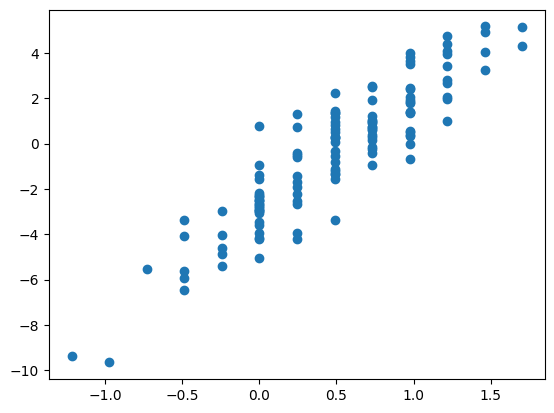

[[1.        0.9099478]
 [0.9099478 1.       ]]


LinregressResult(slope=0.17151243099886115, intercept=0.5551579969989283, rvalue=0.9099477999319261, pvalue=nan, stderr=nan, intercept_stderr=nan)

In [20]:
# REFER: stats.linregress(y_cpu, 8 * (y_mem + x_input.numpy().sum()))
ouput_cpu = x_input.numpy() @ weight_pretrained.T.numpy()
output_mem = quant_reverse(sdk.calculate(x_input.numpy(), addr=addr_fc1, it_time=10).astype(np.float32)-8, scale.numpy(), half_level=7)

# output_mem, ouput_cpu
plt.scatter(output_mem, ouput_cpu)
plt.show()
print(np.corrcoef(output_mem, ouput_cpu))
stats.linregress(ouput_cpu, output_mem)

In [21]:
# Vector-Matrix Multiplication in a expanded scene
def expanded_vmm(sdk, vector_input, weight, pos):
    '''
    input_vector: 
    - shape: should make sure reshaped correctly: .reshape(-1, 1)
    - value: should also be quanted and expanded into (0, 1)
    '''
    weight_addr = [pos[0], pos[1], weight.shape[0], weight.shape[1]]
    ouput_cpu = vector_input.numpy() @ weight.numpy()
    output_mem = quant_reverse(sdk.calculate(vector_input.numpy(), addr=weight_addr, it_time=10).astype(np.float32)-8, np.abs(ouput_cpu).max(), half_level=7)

    return output_mem


expanded_vmm(sdk, x_input, weight_pretrained.T, pos=[0, 0])

array([[ 2.75844,  5.51688, -1.37922, -4.13766,  5.51688,  2.75844,
         2.75844,  1.37922,  4.13766,  6.8961 ,  2.75844,  4.13766,
         5.51688,  5.51688,  5.51688,  2.75844,  0.     ,  0.     ,
         4.13766,  8.27532,  8.27532,  2.75844, -2.75844,  2.75844,
         6.8961 ,  2.75844, -1.37922,  2.75844,  4.13766,  2.75844,
         0.     ,  4.13766,  6.8961 ,  4.13766,  4.13766,  0.     ,
         4.13766, -1.37922,  4.13766,  0.     ,  1.37922,  5.51688,
         4.13766,  1.37922,  1.37922, -1.37922,  5.51688,  4.13766,
         9.65454,  8.27532,  0.     ,  0.     ,  2.75844,  1.37922,
         5.51688,  0.     ,  2.75844,  4.13766,  1.37922,  2.75844,
        -4.13766,  6.8961 ,  5.51688, -1.37922,  4.13766,  6.8961 ,
         2.75844, -6.8961 , -2.75844,  0.     , -1.37922,  2.75844,
         5.51688,  0.     ,  0.     ,  4.13766,  1.37922,  0.     ,
         4.13766,  4.13766,  4.13766,  6.8961 ,  6.8961 ,  4.13766,
         0.     ,  2.75844,  0.     ,  1.37922, 

至此，得到了基本可用的expanded vvm。接下来开始使用这个函数来实现推理。先封装成可用的linear形式：

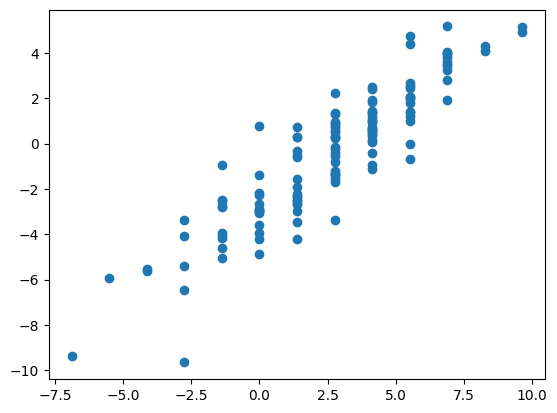

[[1.        0.9099478]
 [0.9099478 1.       ]]


LinregressResult(slope=0.17151243099886115, intercept=0.5551579969989283, rvalue=0.9099477999319261, pvalue=nan, stderr=nan, intercept_stderr=nan)

In [22]:
plt.scatter(expanded_vmm(sdk, x_input, weight_pretrained.T, pos=[0, 0]), x_input.numpy() @ weight_pretrained.T.numpy())
plt.show()
print(np.corrcoef(output_mem, ouput_cpu))
stats.linregress(ouput_cpu, output_mem)

In [23]:
sdk = SDKArray(1)

x_input = torch.randint(0, 2, [12, 196])

def linear(sdk, x_input, weight, pos=[0, 0]):
    x_stack = []
    x_direction = x_input.detach()#.cpu()#.numpy()

    for i, l in enumerate(x_direction):
        x_stack.append(
            expanded_vmm(sdk, l.reshape(1, -1), weight, pos=pos).squeeze(0)
        )

    return torch.tensor(np.array(x_stack))

linear(sdk, x_input, weight_pretrained.T).shape

torch.Size([12, 128])

In [24]:
np.dot(x_input, weight_pretrained.T).shape

(12, 128)

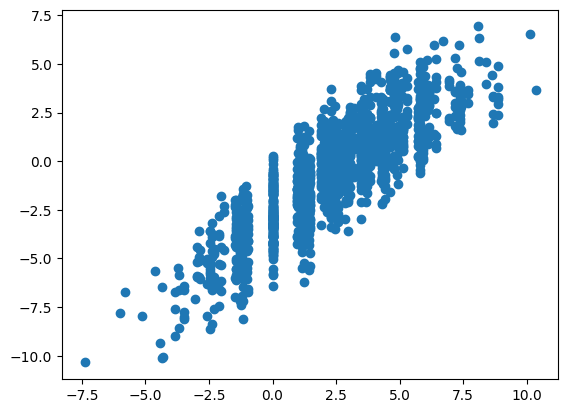

In [25]:
plt.scatter(linear(sdk, x_input, weight_pretrained.T).detach().numpy(), np.dot(x_input, weight_pretrained.T))
plt.show()

In [26]:
stats.linregress(np.dot(x_input, weight_pretrained.T).reshape(1, -1)[0], linear(sdk, x_input, weight_pretrained.T).detach().numpy().reshape(1, -1)[0])

LinregressResult(slope=0.8049462602181494, intercept=2.8089714362837404, rvalue=0.8566192726276107, pvalue=0.0, stderr=0.012378647126251382, intercept_stderr=0.0343415831765415)

# 3. ReRAM MLP 测试

In [27]:
# def quant_and_set_weight():
weight_pretrained = torch.load('model_nobias_2lys.pth')['fc2.weight']
weight_pretrained_quant, scale = quant(weight_pretrained, scale=None, half_level=7)
addr_fc2 = [196, 0, 128, 10]
sdk.set_weight(weight=weight_pretrained_quant.T+8, addr=addr_fc2, verbose = 0, prog_cycle = 5)

(128, 10)
(128, 10)
cell_total_num:1280


Cycle = 1
Progress at 100.00 %
Total time used: 0:00:01
Mapping success rate: 1280 / 1280, 100.0000
Operation success rate: 817 / 817, 100.0000


Cycle = 2
Progress at 100.00 %
Total time used: 0:00:03
Mapping success rate: 1280 / 1280, 100.0000
Operation success rate: 574 / 574, 100.0000


Cycle = 3
Progress at 100.00 %
Total time used: 0:00:03
Mapping success rate: 1280 / 1280, 100.0000
Operation success rate: 504 / 504, 100.0000


Cycle = 4
Progress at 100.00 %
Total time used: 0:00:04
Mapping success rate: 1280 / 1280, 100.0000
Operation success rate: 486 / 486, 100.0000


Cycle = 5
Progress at 100.00 %
Total time used: 0:00:05
Mapping success rate: 1280 / 1280, 100.0000
Operation success rate: 477 / 477, 100.0000


In [28]:
class MemMLP2(torch.nn.Module):
    def __init__(self, p_1=0.5, p_2=0.5):
        super(MemMLP2, self).__init__()
        input_dim, output_dim, hidden_dim = 196, 10, 128
        
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim, bias=False)
        self.weight_1 = self.fc1.weight.detach().numpy()
        self.dropout_1 = torch.nn.Dropout(p_1)
        self.fc2 = torch.nn.Linear(hidden_dim, output_dim, bias=False)
        self.weight_2 = self.fc2.weight.detach().numpy()
        self.dropout_2 = torch.nn.Dropout(p_2)
        # self.fc3 = torch.nn.Linear(hidden_dim, output_dim, bias=False)

    def forward(self, x):
        x = self.dropout_1(x)
        x = self.linear(sdk, x, self.fc1.weight.T, pos=[0, 0])
        x = torch.relu(x)
        x = self.dropout_2(x)
        x = self.linear(sdk, x, self.fc2.weight.T, pos=[196, 0])
        x = torch.relu(x)
        
        # x = torch.relu(self.fc3(x))
        return x

    def linear(self, sdk, x_input, weight, pos=[0, 0]):
        x_stack = []
        x_direction = x_input.detach()#.cpu()#.numpy()

        for i, l in enumerate(x_direction):
            x_stack.append(
                expanded_vmm(sdk, l.reshape(1, -1), weight, pos=pos).squeeze(0)
            )

        return torch.tensor(np.array(x_stack))
    
memnet = MemMLP2(p_1=0.5, p_2=0.5)
memnet.load_state_dict(torch.load('model_nobias_2lys.pth'))

test(memnet)

0.3838

In [29]:
memnet_bsl = MemMLP2(p_1=0.5, p_2=0.5)
memnet_bsl.load_state_dict(torch.load('model_nobias_2lys-baseline.pth'))
test(memnet_bsl)